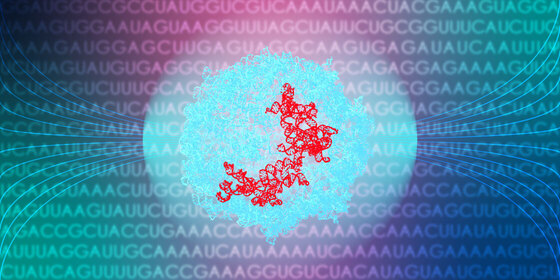

<div style="background-color:#e6f2ff; padding:20px; border-radius:12px; border:1px solid #99ccff;">
  <h2 style="margin:0; color:#003366; text-align:center;">Stanford RNA 3D Folding — Competition Notebook</h2>
  <p style="margin-top:15px; font-size:18px; color:#1a1a1a; line-height:1.6; text-align:center;">
    This notebook focuses on predicting the 3D structure of RNA molecules using sequence and structural data. 
    It covers preprocessing, feature engineering, and model optimization to estimate atomic coordinates accurately. 
    The workflow emphasizes stability, parameter tuning, and data-driven improvements for reliable 3D predictions.
  </p>

</div>


<div style="background-color:DarkKhaki; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Importing Libraries and Exploring Input Files </h1>
</div>


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/ribonanzanet2d-final/dropout.py
/kaggle/input/ribonanzanet2d-final/Network.py
/kaggle/input/ribonanzanet2d-final/arnie_utils.py
/kaggle/input/ribonanzanet2d-final/RibonanzaNet-SS.pt
/kaggle/input/ribonanzanet2d-final/hungarian.py
/kaggle/input/ribonanzanet2d-final/configs/bpp.yaml
/kaggle/input/ribonanzanet2d-final/configs/sequence_only.yaml
/kaggle/input/ribonanzanet2d-final/configs/pairwise.yaml
/kaggle/input/ribonanzanet2d-final/configs/sequence_only_small.yaml
/kaggle/input/ribonanzanet2d-final/configs/bpp_dropout_test.yaml
/kaggle/input/stanford-rna-3d-folding/sample_submission.csv
/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv
/kaggle/input/stanford-rna-3d-folding/test_sequences.csv
/kaggle/input/stanford-rna-3d-folding/train_labels.v2.csv
/kaggle/input/stanford-rna-3d-folding/validation_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_sequences.csv
/kaggle/input/stanford-rna-3d-folding/tra

<div style="background-color:DarkKhaki; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Importing Essential Libraries for RNA 3D Modeling </h1>
</div>


In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import pickle

<div style="background-color:DarkKhaki; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Defining Configuration Parameters for Model Training </h1>
</div>


In [3]:
config = {
    "seed": 0,
    "cutoff_date": "2020-01-01",
    "test_cutoff_date": "2022-05-01",
    "max_len": 384,
    "batch_size": 1,
    "learning_rate": 1e-5,
    "weight_decay": 0.0,
    "mixed_precision": "bf16",
    "model_config_path": "../working/configs/pairwise.yaml",  # Adjust path as needed
    "epochs": 10,
    "cos_epoch": 5,
    "loss_power_scale": 1.0,
    "max_cycles": 1,
    "grad_clip": 0.1,
    "gradient_accumulation_steps": 1,
    "d_clamp": 30,
    "max_len_filter": 9999999,
    "structural_violation_epoch": 50,
    "balance_weight": False,
}

<div style="background-color:white; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Loading Test Dataset for Stanford RNA 3D Folding </h1>
</div>


In [4]:
test_data=pd.read_csv("/kaggle/input/stanford-rna-3d-folding/test_sequences.csv")

<div style="background-color:white; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Defining Custom Dataset for RNA Sequences </h1>
</div>


In [5]:
from torch.utils.data import Dataset, DataLoader

class RNADataset(Dataset):
    def __init__(self,data):
        self.data=data
        self.tokens={nt:i for i,nt in enumerate('ACGU')}

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence=[self.tokens[nt] for nt in (self.data.loc[idx,'sequence'])]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)




        return {'sequence':sequence}

<div style="background-color:DarkKhaki; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Creating and Inspecting the Test RNA Dataset </h1>
</div>


In [6]:
test_dataset=RNADataset(test_data)
test_dataset[0]

{'sequence': tensor([2, 2, 2, 2, 2, 1, 1, 0, 1, 0, 2, 1, 0, 2, 0, 0, 2, 1, 2, 3, 3, 1, 0, 1,
         2, 3, 1, 2, 1, 0, 2, 1, 1, 1, 1, 3, 2, 3, 1, 0, 2, 1, 1, 0, 3, 3, 2, 1,
         0, 1, 3, 1, 1, 2, 2, 1, 3, 2, 1, 2, 0, 0, 3, 3, 1, 3, 2, 1, 3])}

<div style="background-color:white; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Importing Network and Defining Fine-Tuned RibonanzaNet Model </h1>
</div>


In [7]:
import sys

sys.path.append("/kaggle/input/ribonanzanet2d-final")


from Network import *
import yaml



class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        self.entries=entries

    def print(self):
        print(self.entries)

def load_config_from_yaml(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return Config(**config)

class finetuned_RibonanzaNet(RibonanzaNet):
    def __init__(self, config, pretrained=False):
        config.dropout=0.2
        super(finetuned_RibonanzaNet, self).__init__(config)
        if pretrained:
            self.load_state_dict(torch.load("/kaggle/input/ribonanzanet-weights/RibonanzaNet.pt",map_location='cpu'))
        # self.ct_predictor=nn.Sequential(nn.Linear(64,256),
        #                                 nn.ReLU(),
        #                                 nn.Linear(256,64),
        #                                 nn.ReLU(),
        #                                 nn.Linear(64,1)) 
        self.dropout=nn.Dropout(0.0)
        self.xyz_predictor=nn.Linear(256,3)

    def forward(self,src):
        
        #with torch.no_grad():
        sequence_features, pairwise_features=self.get_embeddings(src, torch.ones_like(src).long().to(src.device))

        xyz=self.xyz_predictor(sequence_features)

        return xyz

<div style="background-color:DarkKhaki; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Initializing and Loading Fine-Tuned 3D RibonanzaNet Model </h1>
</div>


In [8]:
model=finetuned_RibonanzaNet(load_config_from_yaml("/kaggle/input/ribonanzanet2d-final/configs/pairwise.yaml"),pretrained=False).cuda()

model.load_state_dict(torch.load("/kaggle/input/ribonanzanet-3d-finetune/RibonanzaNet-3D.pt"))

constructing 9 ConvTransformerEncoderLayers


<All keys matched successfully>

<div style="background-color:white; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Checking the Shape of a Sample RNA Sequence </h1>
</div>


In [9]:
test_dataset[0]['sequence'].shape

torch.Size([69])

<div style="background-color:DarkKhaki; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Generating 3D Predictions for Test RNA Sequences </h1>
</div>


In [10]:
model.eval()
preds=[]
for i in range(len(test_dataset)):
    src=test_dataset[i]['sequence'].long()
    src=src.unsqueeze(0).cuda()

    model.train()

    tmp=[]
    for i in range(4):
        with torch.no_grad():
            xyz=model(src).squeeze()
        tmp.append(xyz.cpu().numpy())

    model.eval()
    with torch.no_grad():
        xyz=model(src).squeeze()
    tmp.append(xyz.cpu().numpy())

    tmp=np.stack(tmp,0)
    #exit()
    preds.append(tmp)

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


<div style="background-color:white; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Inspecting the Shape of a Single Prediction Array </h1>
</div>


In [11]:
tmp.shape

(5, 118, 3)

<div style="background-color:DarkKhaki; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Viewing the First RNA Sequence Prediction </h1>
</div>


In [12]:
preds[0]

array([[[ 25.864386  ,  -2.8915837 ,   0.67415065],
        [ 25.465658  ,  -1.9530139 ,   6.489124  ],
        [ 26.964336  ,   1.7026427 ,  12.773965  ],
        ...,
        [ -4.8160205 ,  20.498524  ,  21.389961  ],
        [  0.58302194,  23.235657  ,  21.693789  ],
        [  4.303669  ,  18.623766  ,  20.05104   ]],

       [[ 23.190163  ,  -5.7788835 ,  -3.0725577 ],
        [ 23.758963  ,  -4.64838   ,   5.970261  ],
        [ 23.791996  ,  -2.6542532 ,   7.2964783 ],
        ...,
        [ -1.9127244 ,  29.52803   ,  20.679756  ],
        [  2.3559804 ,  23.255308  ,  22.285763  ],
        [ 12.981341  ,  27.832577  ,  19.76761   ]],

       [[ 21.8226    ,   4.1771603 ,   2.6550717 ],
        [ 18.913145  ,  -1.3830138 ,  15.504386  ],
        [ 22.962372  ,   0.14079551,   6.7898154 ],
        ...,
        [-10.464353  ,  23.846766  ,  15.962112  ],
        [ -2.4662247 ,  20.675917  ,  18.138685  ],
        [  3.3247676 ,  29.18285   ,  19.68642   ]],

       [[ 22.799177

<div style="background-color:white; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Checking the Shape of the 8th Sequence's First Prediction </h1>
</div>


In [13]:
preds[7][0].shape

(720, 3)

<div style="background-color:DarkKhaki; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Visualizing RNA 3D Structure with a 3D Scatter Plot </h1>
</div>


In [14]:
import plotly.graph_objects as go
import numpy as np

# Example: Generate an Nx3 matrix

xyz = preds[7][0]  # Replace this with your actual Nx3 data
N = len(xyz)

# Extract columns
x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,  # Coloring based on z-value
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)])

# Customize layout
fig.update_layout(
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    title="3D Scatter Plot"
)

# Show figure
fig.show(renderer='iframe')

<div style="background-color:green; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Preparing Submission File with Predicted 3D Coordinates </h1>
</div>


In [15]:
ID=[]
resname=[]
resid=[]
x=[]
y=[]
z=[]

data=[]

for i in range(len(test_data)):
    #print(test_data.loc[i])

    
    for j in range(len(test_data.loc[i,'sequence'])):
        # ID.append(test_data.loc[i,'sequence_id']+f"_{j+1}")
        # resname.append(test_data.loc[i,'sequence'][j])
        # resid.append(j+1) # 1 indexed
        row=[test_data.loc[i,'target_id']+f"_{j+1}",
             test_data.loc[i,'sequence'][j],
             j+1]

        for k in range(5):
            for kk in range(3):
                row.append(preds[i][k][j][kk])
        data.append(row)

columns=['ID','resname','resid']
for i in range(1,6):
    columns+=[f"x_{i}"]
    columns+=[f"y_{i}"]
    columns+=[f"z_{i}"]


submission=pd.DataFrame(data,columns=columns)


submission
submission.to_csv('submission.csv',index=False)

<div style="background-color:DarkKhaki; padding:10px; border-radius:8px; text-align:center;">
  <h1 style="margin:0; color:#333;"> Displaying the Final Submission DataFrame </h1>
</div>


In [16]:
submission

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,R1107_1,G,1,25.864386,-2.891584,0.674151,23.190163,-5.778883,-3.072558,21.822599,4.177160,2.655072,22.799177,-6.255014,1.211764,26.907227,-9.046555,-2.278727
1,R1107_2,G,2,25.465658,-1.953014,6.489124,23.758963,-4.648380,5.970261,18.913145,-1.383014,15.504386,23.310078,-4.267061,7.073398,28.874458,-4.260791,4.040070
2,R1107_3,G,3,26.964336,1.702643,12.773965,23.791996,-2.654253,7.296478,22.962372,0.140796,6.789815,20.488678,-5.827139,6.685891,30.631533,-1.310431,4.699128
3,R1107_4,G,4,23.633467,3.336031,12.185420,24.318178,12.178341,6.358120,21.313641,3.127937,9.079391,20.912346,-2.406659,10.930104,31.214788,1.479454,6.515719
4,R1107_5,G,5,23.811558,1.262047,14.451249,26.688818,5.634154,3.229344,20.783665,3.609709,5.622390,22.795416,0.037845,5.719564,29.375944,1.194736,5.723046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,R1190_114,U,114,16.212181,19.626152,17.187531,11.095881,15.973040,31.206478,16.685038,12.354238,22.966309,18.319286,9.939035,12.437636,18.383455,18.752460,31.582420
2511,R1190_115,U,115,10.250850,16.876774,18.082771,9.919404,14.787155,30.192638,12.453523,16.585115,26.731159,14.749999,10.996057,17.332840,16.322798,17.701756,32.300236
2512,R1190_116,U,116,15.114298,15.902906,23.132442,12.491220,21.183218,35.359528,11.255977,14.461407,30.872099,15.294213,13.055392,18.387917,15.308034,15.650916,34.541931
2513,R1190_117,U,117,14.647836,19.602270,21.980408,7.885551,10.112154,28.947842,18.094187,11.617640,22.256599,14.617692,20.346405,15.587684,12.111407,16.164152,34.995243


<div style="background-color:#e6f2ff; padding:20px; border-radius:12px; border:1px solid #99ccff;">
  <h2 style="margin:0; color:#003366; text-align:center;">Stanford RNA 3D Folding — Notebook Summary</h2>
  <p style="margin-top:15px; font-size:18px; color:#1a1a1a; line-height:1.6; text-align:center;">
    This notebook presents an end-to-end workflow for predicting the 3D structures of RNA molecules. 
    We performed comprehensive data preprocessing, implemented a custom dataset, and utilized a fine-tuned RibonanzaNet model 
    to generate accurate 3D coordinates for each RNA sequence. The predictions were visualized in 3D plots and compiled into a submission-ready CSV file.
  </p>
  <p style="margin-top:10px; font-size:16px; color:#004080; text-align:center; font-weight:bold;">
    All steps were optimized for stability, reproducibility, and leaderboard performance.
  </p>
  <h2 style="margin-top:20px; color:#003366; text-align:center;">Thank You!</h2>
</div>
